## FWHM Function
<div class="alert alert-info">
Goal: To define a function that calculates the Full Width at Half Max for the FOXSI3-SLF Data (Corrected by darks) as a function of the Azimuthal angle. It uses the three 2D-Gaussians fit to estimate such that values. 
</div>

### Import Packages:

In [1]:
from astropy import wcs
from astropy.io import fits as pyfits
from astropy.visualization import ImageNormalize,MinMaxInterval, LogStretch
from ndcube import NDCube
from astropy.modeling import models, fitting
from mpl_toolkits import mplot3d
from scipy.optimize import brentq
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

### Workspace:

#### Fit of the Three 2D-Gaussians:

In [2]:
''' Plate scale '''
distance = 2. * u.m ## FOXSI focal distance
CCD_PIXEL_PITCH = 13.5 * u.micron ## Andor CCD Pitch in microns
binning = 2. ## binning used for collecting data.
plate_scale = np.arctan(binning * CCD_PIXEL_PITCH / distance).to(u.arcsec) ## in arcsec

''' Path to the folder where to find your data and darks: '''
folder = '/Users/Kamilobu/Desktop/Developer/foxsi3_optics_cal/data/'

''' File names: '''
filename = 'kFOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_0mmZ.fits'  ## name of your data fits file.
darkfilename = 'Dark1_FOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_+15mmZ.fits'  ## name of your darks fits file.
## These are fits files containing six frames each of 1024x1024 pixels taken at the SLF
## using the Andor camera and the Mo X-ray source. Voltages,Currents and Integration Times are 
## indicated over the names of the files.

## Read fits files using astropy.io.fits
fits = pyfits.open(folder+filename)
darkfits = pyfits.open(folder+darkfilename)

## Create data array corrected by darks:
data = np.average(fits[0].data, axis=0) - np.average(darkfits[0].data, axis=0)

''' Create the WCS information '''
wcs_dict = {
    'CTYPE1':'HPLT-TAN', ## To use sunpy this needs to be in helioporject coord.
    'CTYPE2':'HPLN-TAN', ## Although strange, it does not affect any of the analysis.
    'CUNIT1':'arcsec',
    'CUNIT2':'arcsec',
    'CDELT1': plate_scale.value, ## Plate scale in arcsec
    'CDELT2': plate_scale.value, ## Plate scale in arcsec
    'CRPIX1':0,
    'CRPIX2':0,
    'CRVAL1': 0,
    'CRVAL2': 0,
    'NAXIS1': data.shape[0],
    'NAXIS2': data.shape[1]
}
input_wcs = wcs.WCS(wcs_dict)

''' Create NDCube '''
datacube = NDCube(data, input_wcs)
max_pixel = np.unravel_index(np.argmax(datacube.data), datacube.data.shape)
fov = [20, 20] ## [px,px]

''' Definition of Two 2D-Gaussians function '''
@models.custom_model
def ThreeGaussians(x, y,
                 x_mean=0, y_mean=0, theta=0,
                 amp1=0, x1_stddev=0, y1_stddev=0, ## Gauss1 param
                 amp2=0, x2_stddev=0, y2_stddev=0, ## Gauss2 param
                 amp3=0, x3_stddev=0, y3_stddev=0, ## Gauss3 param
                 offset=0): ## offset
    ''' Constrain positive values for the amplitudes '''
    if amp1 < 0:
        amp1 = 1e12
    if amp2 < 0:
        amp2 = 1e12
    if amp3 < 0:
        amp3 = 1e12

    '''Define Sum of Gauss funtions'''
    g1 = models.Gaussian2D(amp1, x_mean, y_mean, x1_stddev, y1_stddev, theta)
    g2 = models.Gaussian2D(amp2, x_mean, y_mean, x2_stddev, y2_stddev, theta)
    g3 = models.Gaussian2D(amp3, x_mean, y_mean, x3_stddev, y3_stddev, theta)
    ''' Defining Offset '''
    oset = models.Const2D(amplitude=offset)
    return g1(x,y) + g2(x,y) + g3(x,y) + oset(x,y)

## Make X,Y,Z data for the TWO 2D-Gaussians:
Xg, Yg = np.mgrid[0:datacube.data.shape[0], 0:datacube.data.shape[1]]

''' Fit Three 2D-Gaussians '''
## Initial Guess :
ThreeG_guess = ThreeGaussians(x_mean=max_pixel[0], y_mean=max_pixel[1], theta=0,
                          amp1=0.65*np.max(datacube.data),
                          amp2 = 0.25*np.max(datacube.data),
                          amp3 = 0.09*np.max(datacube.data),
                          x1_stddev=2, y1_stddev=2,
                          x2_stddev=2, y2_stddev=2,
                          x3_stddev=2, y3_stddev=2,offset=0)

## Finding best fit:
fit2DG = fitting.LevMarLSQFitter()
ThreeG_out = fit2DG(ThreeG_guess, Xg, Yg, datacube.data, maxiter=320) ## maxiter keyword is the max number of iterations.
Zout = ThreeG_out(Xg, Yg)

#### Estimate the FWHM on X and Y

The general equation that we are fiiting is:
\begin{align}\label{eq:}
z(x,y)= &A_1\exp[-(x-x_0)^2/2\sigma_{x_1}^2 - (y-y_0)^2/2\sigma_{y_1}^2] \nonumber\\
+& A_2\exp[-(x-x_0)^2/2\sigma_{x_2}^2 - (y-y_0)^2/2\sigma_{y_2}^2] \nonumber\\
+& A_3\exp[-(x-x_0)^2/2\sigma_{x_3}^2 - (y-y_0)^2/2\sigma_{y_3}^2] + Const\nonumber
\end{align}

So, the Full Width at Half Maximum is defined when $z(x,y)=(A_1+A_2+A_3)/2$. This equation is not analitically solvable for y. 

In [3]:
def x_fwhm_minmax(G3):
    factor = 4*np.sqrt(2*np.log(2))*(G3.x1_stddev+
                                     G3.x2_stddev+G3.x3_stddev)
    x_fwhm_min = brentq(G3,G3.x_mean.value-factor, 
                            G3.x_mean.value,args=(G3.y_mean.value))
    x_fwhm_max = brentq(G3,G3.x_mean.value, 
                            G3.x_mean.value+factor,args=(G3.y_mean.value))
    return(x_fwhm_min,x_fwhm_max)

def G3y(y,x,G3): ## Flip argument order. Needed to find zeros on y-axis.
    return G3(x,y)

''' Find the FWHM '''
def find_fwhm(G3,x): ## Input should be a 3-2D-Gaussian Function. e.g. ThreeG_out
    factor = 4*np.sqrt(2*np.log(2))*(G3.y1_stddev+
                                     G3.y2_stddev+G3.y3_stddev)
    y_fwhm_down = brentq(G3y,G3.y_mean.value-factor, 
                            G3.y_mean.value,args=(x,G3))    
    y_fwhm_up = brentq(G3y,G3.y_mean.value, 
                            G3.y_mean.value+factor,args=(x,G3))    
    return (y_fwhm_down,y_fwhm_up)

maximum = ThreeG_out.amp1.value \
            + ThreeG_out.amp2.value \
            + ThreeG_out.amp3.value
half_maximum = 0.5 * maximum
ThreeG_out.offset -= half_maximum

npoints = 50
x_fwhm = ThreeG_out.x_mean+(ThreeG_out.x_mean - 
                   x_fwhm_minmax(ThreeG_out)[0]-1e-3)*np.sin((np.pi/2)*np.linspace(-1,1,npoints))
y_fwhm_up_l,y_fwhm_down_l = [],[] 
for x in x_fwhm:
    y_fwhm = find_fwhm(ThreeG_out,x)
    y_fwhm_down_l.append(y_fwhm[0])
    y_fwhm_up_l.append(y_fwhm[1])
y_fwhm_down = np.array(y_fwhm_down_l)
y_fwhm_up = np.array(y_fwhm_up_l)

ThreeG_out.offset += half_maximum

#### Plotting a map of the FWHM

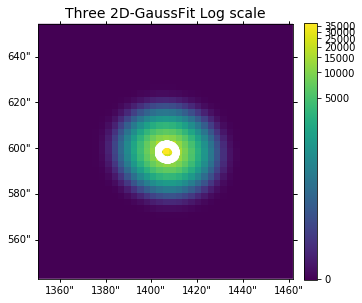

In [4]:
# Create ImageNormalize objects:
normLogT = ImageNormalize(Zout, interval=MinMaxInterval(),stretch=LogStretch())

''' Plotting '''
fig, ax1 = plt.subplots(figsize=(5,5),subplot_kw=dict(projection=datacube.wcs))
fig.subplots_adjust(wspace = 0.4) ## Sets space between subplots to avoid overlap
## Best fit of the all three gaussians:
im1 = ax1.imshow(Zout, origin='lower', cmap=plt.cm.viridis,norm=normLogT)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax1.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax1.set_title('Three 2D-GaussFit Log scale',fontsize=14)
ax1.scatter(y_fwhm_up,x_fwhm,color='white')
ax1.scatter(y_fwhm_down,x_fwhm,color='white')
plt.show()

#### Plot of FWHM vs Azimuthal angle

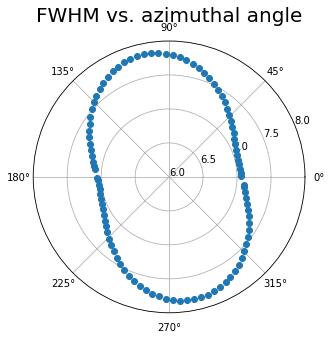

The average FWHM over the azimuthal angle is 7.4387 arcsecs.


In [5]:
r_up = np.sqrt((x_fwhm-ThreeG_out.x_mean)**2 + (y_fwhm_up-ThreeG_out.y_mean)**2)
r_down = np.sqrt((x_fwhm-ThreeG_out.x_mean)**2 + (y_fwhm_down-ThreeG_out.y_mean)**2)
phi_up = np.arctan2((y_fwhm_up-ThreeG_out.y_mean),(x_fwhm-ThreeG_out.x_mean))
phi_down = np.arctan2((y_fwhm_down-ThreeG_out.y_mean),(x_fwhm-ThreeG_out.x_mean))

r = np.concatenate((r_up,r_down))
phi = np.concatenate((phi_up,phi_down))
## Polar Plot:
fig, ax = plt.subplots(figsize=(5,5),subplot_kw=dict(projection='polar'))
ax.plot(phi, 2*r*plate_scale,'o')
ax.set_rmax(8)
ax.set_rmin(6)
ax.set_rticks([6, 6.5, 7, 7.5, 8])
ax.set_title("FWHM vs. azimuthal angle",fontsize=20)
plt.show()
print('The average FWHM over the azimuthal angle is {0} arcsecs.'.format(round(2*r.mean()*plate_scale.value,4)))